## Dataset Generator
Create csv dataset from given tsv files and add path of audio clips

In [1]:
import os
import pandas as pd

In [2]:
# Provide path to "data" folder inside "speech_project_main"
data_dir = "E:\College\Codes\Python\Machine Learning\Speech Processing\speech_project_main\data"   #Provide path
df_list = []
for i in range(3):
    tsv_path = os.path.join(data_dir, f"validated{i+1}.tsv")
    clips_path = os.path.join(data_dir, f"clips{i+1}")

    temp_df = pd.read_csv(tsv_path, sep="\t", usecols=["path", "gender", "age"])
    temp_df["path"] = temp_df["path"].apply(lambda x: os.path.join(clips_path, x))
    df_list.append(temp_df)

# Combine all TSVs
df = pd.concat(df_list, ignore_index=True)


In [3]:
df.head()

,path,age,gender
0,E:\College\Codes\Python\Machine Learning\Speec...,twenties,male
1,E:\College\Codes\Python\Machine Learning\Speec...,NaN,NaN
2,E:\College\Codes\Python\Machine Learning\Speec...,NaN,NaN
3,E:\College\Codes\Python\Machine Learning\Speec...,NaN,NaN
4,E:\College\Codes\Python\Machine Learning\Speec...,NaN,NaN


In [4]:
print(df.gender.unique())
print(df.age.unique())

['male' nan 'female' 'other' 'male_masculine' 'female_feminine']
['twenties' nan 'fourties' 'teens' 'thirties' 'fifties' 'sixties']


In [5]:
gender_mapping = {
    'male': 0,
    'male_masculine': 0,
    'female': 1,
    'female_feminine': 1
}

df['gender_label'] = df['gender'].map(gender_mapping)
df = df[df['gender_label'].notna()]
df = df[df['age'].notna()]
df['gender_label'] = df['gender_label'].astype(int)

In [6]:
# to CSV
csv_df = df[['path', 'gender_label', 'age']].rename(columns={
    'path' : 'file_path',
    'gender_label': 'gender',
    'age': 'age_group'
})

# Separate genders
male_df = csv_df[csv_df['gender'] == 0]
female_df = csv_df[csv_df['gender'] == 1]

# downsample male = 2 * female
desired_male_count = 2 * len(female_df)
male_downsampled = male_df.sample(n=desired_male_count, random_state=42)

# Combine and shuffle
reduced_imbalance_df = pd.concat([male_downsampled, female_df]).sample(frac=1, random_state=42)

# Save to CSV
reduced_imbalance_df.to_csv('final_csv_dataset.csv', index=False)
print('final_csv_dataset.csv created.')

final_csv_dataset.csv created.


## Model Development

In [7]:
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv("final_csv_dataset.csv")  # replace with your actual CSV path
df.head()

,file_path,gender,age_group
0,E:\College\Codes\Python\Machine Learning\Speec...,0,thirties
1,E:\College\Codes\Python\Machine Learning\Speec...,0,twenties
2,E:\College\Codes\Python\Machine Learning\Speec...,0,twenties
3,E:\College\Codes\Python\Machine Learning\Speec...,0,twenties
4,E:\College\Codes\Python\Machine Learning\Speec...,1,twenties


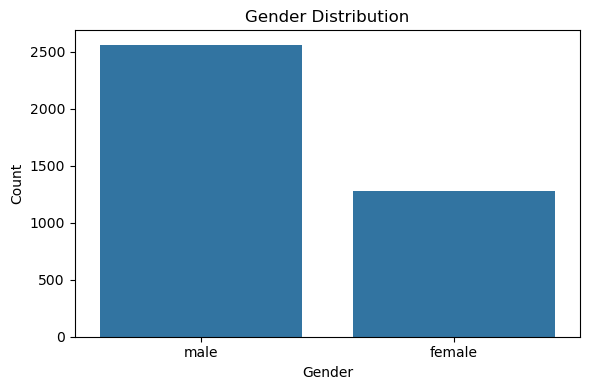

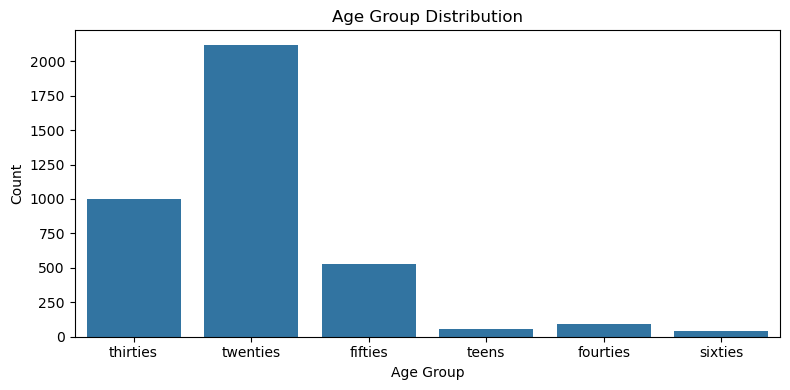

In [31]:
# Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender')
plt.title("Gender Distribution")
plt.xticks(ticks=[0,1], labels=["male", "female"])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Age group distribution
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='age_group')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [10]:
# Feature extraction defination using MFCC
def extract_features(file_path, sr=44100):
    y, _ = librosa.load(file_path, sr=sr, mono=True)

    # 13 MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # 13 delta MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)

    # 13 delta-delta MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    # Pitch & Magnitude
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.max(pitches)
    magnitude = np.max(magnitudes)

    # Stack features: shape = (time_steps, features)
    features = np.vstack((mfccs, delta_mfccs, delta2_mfccs))

    # Transpose to shape (time_steps, 39)
    features = features.T

    # Add pitch & magnitude to each frame
    pitch_mag = np.full((features.shape[0], 2), [pitch, magnitude])
    full_features = np.hstack((features, pitch_mag))  # (time_steps, 41)

    return full_features

In [11]:
# Encode age
age_group_map = {
    'teens': 0,
    'twenties': 1,
    'thirties': 2,
    'fourties': 3,
    'fifties': 4,
    'sixties': 5
}

df['age_group'] = df['age_group'].map(age_group_map)

In [12]:
# Extract features
X = []
y_gender = []
y_age = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['file_path'])

    # Optional: pad/truncate to fixed length, e.g., 200 time steps
    max_len = 200
    if features.shape[0] < max_len:
        pad_width = max_len - features.shape[0]
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    else:
        features = features[:max_len, :]

    X.append(features)
    y_gender.append(row['gender'])
    y_age.append(row['age_group'])

X = np.array(X)
y_gender = to_categorical(y_gender, 2)
y_age = to_categorical(y_age)

100%|██████████| 3837/3837 [03:19<00:00, 19.22it/s]


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Flatten time-major axis for normalization
X_flat = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)
X = X_flat.reshape(X.shape)

# Split data
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_gender_model(input_shape):
    model = Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        LSTM(100),
        Dropout(0.2),
        Dense(2, activation='softmax', kernel_regularizer=l2(0.001))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

gender_model = build_gender_model((X.shape[1], X.shape[2]))
gender_model.summary()


# Model Training
gender_history = gender_model.fit(
    X_train, y_gender_train,
    validation_data=(X_val, y_gender_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 100)          56800     
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 137,402
Trainable params: 137,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [==============================] 

In [15]:
# Age model
def build_age_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

age_model = build_age_model((X.shape[1], X.shape[2]), y_age.shape[1])
age_model.summary()

age_history = age_model.fit(X_train, y_age_train, validation_data=(X_val, y_age_val),
              epochs=30, batch_size=128, callbacks=[early_stop])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 128)          87040     
                                                                 
 dropout_2 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 235,910
Trainable params: 235,910
Non-tr

In [16]:
# Evaluate models
loss_g, acc_g = gender_model.evaluate(X_val, y_gender_val)
loss_a, acc_a = age_model.evaluate(X_val, y_age_val)

print(f"Gender Model - Accuracy: {acc_g:.2f}, Loss: {loss_g:.2f}")
print(f"Age Model - Accuracy: {acc_a:.2f}, Loss: {loss_a:.2f}")


24/24 [==============================] - 3s 67ms/step - loss: 0.3094 - accuracy: 0.9297
Gender Model - Accuracy: 0.98, Loss: 0.16
Age Model - Accuracy: 0.93, Loss: 0.31


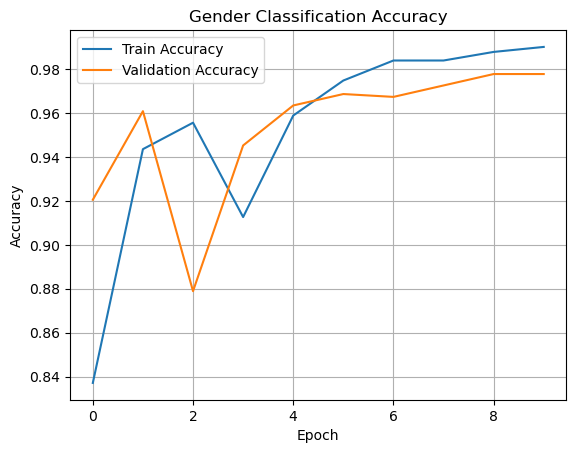

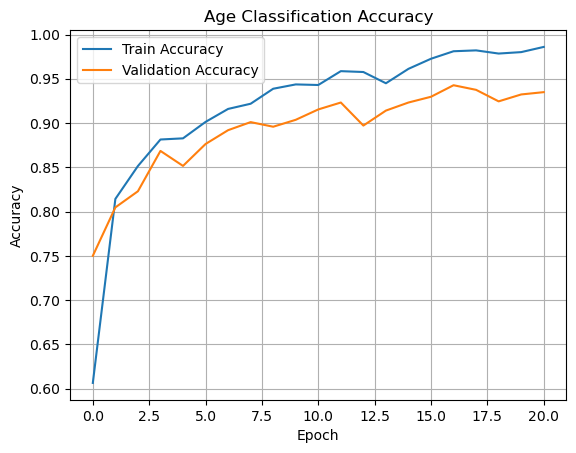

In [17]:
# Plot accuracy (train vs validation)
def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(gender_history, 'Gender Classification')
plot_accuracy(age_history, 'Age Classification')

In [18]:
# Save models
gender_model.save('gender_lstm_model.h5')
age_model.save('age_lstm_model.h5')

print("Models saved successfully!")

Models saved successfully!


## Real-Time prediction GUI
The following code will only work if you are using GOOGLE COLAB

To use the gui locally (i.e. on vscode or jupyter) run the last few commented cells instid

In [19]:
#!pip install gradio librosa soundfile

In [20]:
import gradio as gr
import numpy as np
import librosa
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import os

d:\Anaconda\envs\Anaconda_CPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# PROVIDE PATH to both models if path not found
gender_model = load_model('gender_lstm_model.h5')   #Provide path
age_model = load_model('age_lstm_model.h5')

# Verify models loaded correctly
print("Models loaded successfully!")
print(f"Gender model output shape: {gender_model.output_shape}")
print(f"Age model output shape: {age_model.output_shape}")

Models loaded successfully!
Gender model output shape: (None, 2)
Age model output shape: (None, 6)


In [22]:
gender_labels = ['male', 'female']
age_labels = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties']

In [23]:
def extract_features(file_path, sr=44100, max_len=200):
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    magnitude = np.mean(magnitudes) if np.any(magnitudes > 0) else 0

    features = np.vstack((mfccs, delta, delta2)).T
    pitch_mag = np.full((features.shape[0], 2), [pitch, magnitude])
    full_features = np.hstack((features, pitch_mag))

    if full_features.shape[0] < max_len:
        pad_width = max_len - full_features.shape[0]
        full_features = np.pad(full_features, ((0, pad_width), (0, 0)), mode='constant')
    else:
        full_features = full_features[:max_len, :]

    scaler = StandardScaler()
    full_features = scaler.fit_transform(full_features)
    return np.expand_dims(full_features, axis=0)

In [24]:
def predict_from_audio(file_path):
    print(f"[DEBUG] File received: {file_path}")

    if file_path is None or not os.path.exists(file_path):
        return "No audio recorded. Please try again."

    try:
        features = extract_features(file_path)

        gender_pred = gender_model.predict(features, verbose=0)[0]
        age_pred = age_model.predict(features, verbose=0)[0]

        gender = gender_labels[np.argmax(gender_pred)]
        age = age_labels[np.argmax(age_pred)]

        gender_conf = round(float(np.max(gender_pred)) * 100, 2)
        age_conf = round(float(np.max(age_pred)) * 100, 2)

        result = f"Gender: {gender} (Confidence: {gender_conf}%)\n"
        result += f"Age group: {age} (Confidence: {age_conf}%)"

        return result

    except Exception as e:
        return f"Error during prediction: {str(e)}"

In [ ]:
# Gradio interface
demo = gr.Interface(
    fn=predict_from_audio,
    inputs=gr.Audio(sources=["microphone"], type="filepath", label="Record your voice (5 sec max)"),
    outputs="text",
    title="Voice-Based Age & Gender Prediction",
    description="Speak clearly for 1–5 seconds, then submit. The system will predict your gender and approximate age group based on voice.",
)

print('''Instructions:
1) Click on the public URL below.
2) Press RECORD on left side, it might ask for mic permissions so provide it.
3) Record an audio of max 5s and press STOP. Then press SUBMIT to submit the audio. The result can be seen on right-side pane.

NOTE - You might need to press SUBMIT a few times to get the result. :) ''')

demo.launch(share=True)